<h1>А/В тестирование<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичное-знакомство" data-toc-modified-id="Первичное-знакомство-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичное знакомство</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Иследовательский-анализ-данных" data-toc-modified-id="Иследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Иследовательский анализ данных</a></span></li><li><span><a href="#Оценка-результата-A/B-тестирования" data-toc-modified-id="Оценка-результата-A/B-тестирования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка результата A/B-тестирования</a></span></li><li><span><a href="#Вывод-и-рекомендации" data-toc-modified-id="Вывод-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод и рекомендации</a></span></li></ul></div>

**Цель: провести оценку результатов A/B-теста и вернуться с итоговыми выводами/рекомендациями. Тест подразумевал увеличение конверсии по каждой метрике на 10 и более %**

**А — контрольная, B — новая платёжная воронка**

**Техническое задание:**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**План исследования**
1. Первичное знакомство
- Изучить все таблицы, которые необходимы для корректного анализа A/B теста
- Загрузить все необходимые библиотеки

2. Предобработка данных:
- преобразовать поля с датами во всех датафреймах в тип datetime
- проанализировать пропуски. Имеются только в датафрейме final_ab_events в поле details. Заполнять не будем, так как природа пропусков очевидна - связана со спецификой заполнения данного поля, заполняется только при событии purchase
- дубликаты отсутствуют
- приводить к нижнему регистру не требуется
- проверить условия ТЗ и почистить/обрезать данные при необходимости
- сформировать итоговый датафрейм с пользователями и событиями, в том числе проверить распределение групп А и В
- добавить новый столбец с датами для дальнейшего анализа
- удалить события, которые могут исказить результаты теста

3. Исследовательский анализ данных:
- проверить количество событий на пользователя, одинаково ли распределены в выборках
- посмотреть, какие события есть в логах, как часто они встречаются,в том числе посчитать события по уникальным пользователям
- проверить как число событий в выборках распределено по дням
- проверить как меняется конверсия в воронке в выборках на разных этапах
- описать какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию

4. Оценить результаты A/B-тестирования
- проверить статистическую разницу долей z-критерием
    
5. Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделать общее заключение о корректности проведения теста

## Первичное знакомство

In [1]:
%pip install -U kaleido -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
#загрузила библиотеки
import pandas as pd
import scipy.stats as stats
import math as mth
import datetime as dt
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default="png"
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

In [3]:
#загрузила датафрейм - календарь маркетинговых событий на 2020 год
try:
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    ab_project_marketing_events = pd.read_csv(r"C:\scripts\ab_project_marketing_events.csv")
    
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
#загрузила датафрейм - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
try:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
except:
    final_ab_events = pd.read_csv(r"C:\scripts\final_ab_events.csv")

final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
#загрузила датафрейм - пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
try:
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    final_ab_new_users = pd.read_csv(r"C:\scripts\final_ab_new_users.csv")

final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
#загрузила датафрейм - таблица участников тестов
try:
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    final_ab_participants = pd.read_csv(r"C:\scripts\final_ab_participants.csv")

final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


## Предобработка данных

In [7]:
#посмотрела информацию по колонкам
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id    

In [8]:
#преобразовала поля с датами
ab_project_marketing_events['start_dt'] = ab_project_marketing_events['start_dt'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [9]:
ab_project_marketing_events['finish_dt'] = ab_project_marketing_events['finish_dt'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [10]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format='%Y-%m-%dT%H:%M:%S')

In [11]:
final_ab_new_users['first_date'] = final_ab_new_users['first_date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [12]:
#посмотрела датафреймы после преобразования полей с датами
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732


In [13]:
#проверила на пропуски каждый датафрейм
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    print(row.isna().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
user_id       0
first_date    0
region        0
device        0
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64


Пропуски только в датафрейме final_ab_events в поле details

In [14]:
#дополнительно проверила пропуски в датафрейме final_ab_events в поле details
def det (x):
    result = {
        'count_nan': x['details'].isna().sum()
    }
    return pd.Series(result)

final_ab_events.groupby(['event_name']).apply(det)

,count_nan
event_name,
login,189552
product_cart,62462
product_page,125563
purchase,0


Наличие пропусков обусловлено тем, что поле заполняется только при событии purchase

In [15]:
#проверила на дубликаты
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    print('Кол-во дубликатов -', row.duplicated().sum())

Кол-во дубликатов - 0
Кол-во дубликатов - 0
Кол-во дубликатов - 0
Кол-во дубликатов - 0


Дубликаты отсутствуют

In [16]:
#посмотрела минимальный и максимальный день события
print(final_ab_events['event_dt'].min())
print(final_ab_events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Тест закончился раньше, чем предполагалось. AS IS - 4 января, TO BE - 30 декабря. Необходимо предположить с чем связано

In [17]:
#посмотрела минимальный и максимальный день регистрации
users_test = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']
users_test_ab = users_test.merge(final_ab_new_users, on='user_id', how='inner')
print(users_test_ab ['first_date'].min())
print(users_test_ab ['first_date'].max())

2020-12-07 00:00:00
2020-12-21 00:00:00


По событию регистрация мы владеем данными с 7.12 по 21.12

In [18]:
#проверка условиям ТЗ - 15% новых пользователей из региона EU
#считаем кол-во зарегистрированных пользователей с 7.12 по 21.12
new_users_eu = final_ab_new_users[(final_ab_new_users['region']=='EU') & (final_ab_new_users['first_date'] <= '2020-12-21')]['user_id'].nunique()
print ('Кол-во новых пользоватлей из EU, зарегистрированных с 7 декабря по 21 декабря 2020 -', new_users_eu)

Кол-во новых пользоватлей из EU, зарегистрированных с 7 декабря по 21 декабря 2020 - 42340


In [19]:
#проверим исходный датафрейм по уникальным значениям тестов
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

2 теста: interface_eu_test и recommender_system_test

In [20]:
#считаем кол-во участников теста recommender_system_test из EU
users_test_ab_eu = users_test_ab[users_test_ab['region'] == 'EU']['user_id'].nunique()
print ('Кол-во новых пользователей из EU, которые участвуют в тесте -', users_test_ab_eu)

Кол-во новых пользователей из EU, которые участвуют в тесте - 6351


In [21]:
print('Доля пользователей, которые участвует в тесте из EU -', round(users_test_ab_eu/new_users_eu * 100), '%')

Доля пользователей, которые участвует в тесте из EU - 15 %


По условиям ТЗ 15% новых пользователей должны быть из региона EU - соблюдено

In [22]:
#приступаем к чистке данных
print ('Кол-во уникальных пользователей в тесте - ', users_test_ab['user_id'].nunique())

Кол-во уникальных пользователей в тесте -  6701


До очистки кол-во уникальных пользователей в тесте recommender_system_test - 6701

In [23]:
#проверила, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно
users_test_ab.groupby('group')['user_id'].nunique()

group
A    3824
B    2877
Name: user_id, dtype: int64

In [24]:
total_A = users_test_ab.query('group == "A"')['user_id'].nunique()
total_B = users_test_ab.query('group == "B"')['user_id'].nunique()
print('Группа А больше группы В на -', round(total_A/total_B*100)-100, '%')

Группа А больше группы В на - 33 %


Между группами нет пересечений, сумма равняется общему количеству пользователей.Они распределены неравномерно, так как группа А на 33% больше группы B

In [25]:
duplicate = (
    final_ab_participants.groupby('user_id')
    .agg({'ab_test': 'nunique'})
    .sort_values(by='ab_test', ascending=False)
    .reset_index()
    .query('ab_test == 2')
)
print ('Кол-во пользователей, которые пересекаются с конкурирующим тестом -', duplicate['user_id'].nunique())

Кол-во пользователей, которые пересекаются с конкурирующим тестом - 1602


1602 пользователя фигурируют в обоих тестах, необходимо удалить их из теста recommender_system_test, так как их поведение нельзя оценивать как релевантное(на поведение может повлиять несколько факторов)

In [26]:
#удалила пользователей, которые участвуют в двух тестах одновременно и посмотрела распределение
users_test_ab_group = (
    users_test_ab.query('user_id not in @duplicate["user_id"]')
                        .groupby('group')['user_id']
                        .nunique()
)
users_test_ab_group

group
A    2903
B    2196
Name: user_id, dtype: int64

In [27]:
total_A_new = users_test_ab.query('user_id not in @duplicate["user_id"] and group=="A"')['user_id'].nunique()
total_B_new = users_test_ab.query('user_id not in @duplicate["user_id"] and group=="B"')['user_id'].nunique()

print('Группа А больше группы В на -', round(total_A_new/total_B_new*100)-100, '%')

Группа А больше группы В на - 32 %


Группы распределены неравномерно, группа А больше группа В на 32%. Также после очистки датафрейма от user_id, которые участвуют в конкурирующем тесте, выборка уменьшилась и составляет уже 5099 шт

In [28]:
#подготовила итоговый датафрейм с пользователями после очистки
users_test_ab_new =  users_test_ab.query('user_id not in @duplicate["user_id"]')
users_test_ab_new

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
5,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac
6,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone
...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


In [29]:
#соединила логи с событиями и итоговый датафрейм с пользователями
test_ab_new = users_test_ab_new.merge(final_ab_events, on='user_id', how='left')
test_ab_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   first_date  21115 non-null  datetime64[ns]
 4   region      21115 non-null  object        
 5   device      21115 non-null  object        
 6   event_dt    18804 non-null  datetime64[ns]
 7   event_name  18804 non-null  object        
 8   details     2483 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


Пропуски есть в столбцах event_dt и event_name. Означает, что данные клиенты только зарегистрировались, более не выполняли действия или по техническим причинам им не пришел логин/далее не пошли по процессу. Для расчета изначальной воронки будут нам полезны, а также этот факт необходимо зафиксировать в выводах

In [30]:
#заполнила пропуски в event_name значением registration
test_ab_new['event_name'] = test_ab_new['event_name'].fillna('registration')
test_ab_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   first_date  21115 non-null  datetime64[ns]
 4   region      21115 non-null  object        
 5   device      21115 non-null  object        
 6   event_dt    18804 non-null  datetime64[ns]
 7   event_name  21115 non-null  object        
 8   details     2483 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


Заполнила пропуски в поле event_name значением registration, так как пользователи, которые остановились на регистрации нам тоже полезны

In [31]:
#заполнила пропуски в event_dt значением из first_date
test_ab_new['event_dt'] = test_ab_new['event_dt'].fillna(test_ab_new['first_date'])
test_ab_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   first_date  21115 non-null  datetime64[ns]
 4   region      21115 non-null  object        
 5   device      21115 non-null  object        
 6   event_dt    21115 non-null  datetime64[ns]
 7   event_name  21115 non-null  object        
 8   details     2483 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


Заполнила пропуски в поле event_dt значением из first_date, так как по логам видно, что кроме регистрации, у пользователей событий не было, значит можно смело считать, что first_date = event_dt

In [32]:
#добавила поле с датами событий
test_ab_new.insert(7, 'day', test_ab_new['event_dt'].dt.day, True)
test_ab_new

,user_id,group,ab_test,first_date,region,device,event_dt,day,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,7,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,25,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,7,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,25,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,7,product_page,NaN
...,...,...,...,...,...,...,...,...,...,...
21110,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,7,login,NaN
21111,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,8,login,NaN
21112,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,9,login,NaN
21113,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,10,login,NaN


In [33]:
#посмотрела, что все 5099 уникальных клиентов фигурируют в итоговом датафрейм с логами
total_test = test_ab_new['user_id'].nunique()
total_test

5099

In [34]:
#проверила итоговый датафрейм на дубликаты
test_ab_new.duplicated().sum()

0

In [35]:
#посмотрела скоько всего событий в итоговом датафрейме
total = test_ab_new['event_name'].count()
print('Всего событий в итоговом датафрейме -', total)

Всего событий в итоговом датафрейме - 21115


In [36]:
#изучила файл с маркетинговыми активностями
ab_project_marketing_events.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


In [37]:
#отфильтровала таблицу ab_project_marketing_events по дате и региону проведения теста (EU)
ab_project_marketing_events.query('start_dt >= "2020-12-07" and regions.str.contains("EU")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время проведения теста зафиксирована маркетинговая активность Christmas&New Year Promo

In [38]:
#удалила события,которые произошли через 14 после регистрации
test_ab_new['delta'] = test_ab_new['event_dt'] -  test_ab_new['first_date']
d15 = pd.Timedelta(days=15)
test_ab_new = test_ab_new[test_ab_new[ 'delta' ] <= d15].copy()
print('Всего событий в итоговом датафрейме -', test_ab_new['event_name'].count())

Всего событий в итоговом датафрейме - 20640


In [39]:
print('Итоговая потеря данных составила -', round(100-(test_ab_new['event_name'].count()/total*100)),'%', ',', total-test_ab_new['event_name'].count())

Итоговая потеря данных составила - 2 % , 475


Итоговая потеря данных составила 2% от изначального кол-ва событий в итоговом датафрейме

In [40]:
#посморела еще раз на новый датафрейм
test_ab_new.sort_values(by='delta', ascending=False)

,user_id,group,ab_test,first_date,region,device,event_dt,day,event_name,details,delta
14903,6E3DF9C69A6B607E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-28 23:22:32,28,product_page,NaN,14 days 23:22:32
14910,6E3DF9C69A6B607E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-28 23:22:32,28,login,NaN,14 days 23:22:32
14896,6E3DF9C69A6B607E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-28 23:22:32,28,product_cart,NaN,14 days 23:22:32
4289,EAA6967BB9807DF2,A,recommender_system_test,2020-12-08,EU,PC,2020-12-22 22:54:40,22,product_page,NaN,14 days 22:54:40
4293,EAA6967BB9807DF2,A,recommender_system_test,2020-12-08,EU,PC,2020-12-22 22:54:38,22,login,NaN,14 days 22:54:38
...,...,...,...,...,...,...,...,...,...,...,...
19104,08530541B3E53C8A,B,recommender_system_test,2020-12-21,EU,iPhone,2020-12-21 00:00:00,21,registration,NaN,0 days 00:00:00
19105,3A8B9884EF17D2B3,A,recommender_system_test,2020-12-08,EU,iPhone,2020-12-08 00:00:00,8,registration,NaN,0 days 00:00:00
19106,E6BD9A774D155DEE,A,recommender_system_test,2020-12-08,EU,PC,2020-12-08 00:00:00,8,registration,NaN,0 days 00:00:00
19107,53F5CBB3C34747E5,A,recommender_system_test,2020-12-12,EU,iPhone,2020-12-12 00:00:00,12,registration,NaN,0 days 00:00:00


In [41]:
#распределение пользователей теста по региональной принадлежности по очищенным данным
region = test_ab_new.groupby('region').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
region['per'] = round(region['user_id']/total_test*100, 2)
region

,user_id,per
region,,
EU,4749,93.14
N.America,223,4.37
APAC,72,1.41
CIS,55,1.08


Большинство пользователей из EU (93%), 4% - N.America и по 1% - APAC и CIS, удалять пользователей не будем, так как на 7% снизится кол-во ползователей в тесте, тем самым риск "ложных" выводов вырастет	

**Промежуточный вывод**

1. После чистки пересекающихся id с конкурирующем тестом мы потеряли 24% данных
2. Не исключила события, которые произошли во время маркетинговой активности Christmas&New Year Promo, так как не знаем ни деталей проведения маркетинговой кампании, ни сферы работы нашего приложения
3. Исключила события, которые совершены через 14 дней после даты регистрации в соответствии с ТЗ
4. Итоговая потеря данных составила 2% от изначального кол-ва событий в итоговом датафрейме, в количестве - 475 событий
4. Группы А и В после очищения распределены неравномерно, группа А на 32% больше группы B
5. Большинство пользователей из EU (93%), 4% - N.America и по 1% - APAC и CIS	
6. Тест закончили раньше, предполагаю из-за праздников
7. Не все пункты ТЗ (ниже) предусмотрены, проанализировать результаты можно, но могут быть искажены


**Пункты ТЗ**
- тест завершен раньше, что влияет на объем данных, дата старта теста не изменилась - соблюдено частично
- 15% новых пользователей из региона EU - соблюдено
- ожидаемое количество участников теста: 6000 - соблюдено частично из-за очистки. Итоговая выборка состоит из 5 тыс пользователей
- ожидаемый эффект: за 14 дней с момента регистрации проверить изменение метрик - соблюдено

## Иследовательский анализ данных

In [42]:
#посмотрела распределение кол-во событий на одного пользователя в выборках
test_ab_new.query('group == "A"').groupby('user_id').agg({'event_name':'count'}).describe()

,event_name
count,2903.000000
mean,5.263520
std,4.222507
min,1.000000
25%,1.000000
50%,4.000000
75%,8.000000
max,24.000000


In [43]:
test_ab_new.query('group == "B"').groupby('user_id').agg({'event_name':'count'}).describe()

,event_name
count,2196.000000
mean,2.440801
std,2.819013
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,24.000000


В группе А по среднему значению кол-во событий - 5,2, по медиане - 4

В группе В по среднему значению кол-во событий - 2,4, по медиане - 1

Говорит о том, что в обоих группах присутствуют выбросы (скорей всего один пользователь совершал несколько покупок), но и распределение по событиям отличаются между группами. 

За основу будем брать медианное значение: в группе А - 4 события, в группе B - 1 событие. В группе А медиана значительно выше

In [44]:
#посчитала, какие события есть в логах, как часто они встречаются
test_ab_new.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
login,8274
product_page,5158
product_cart,2473
purchase,2424
registration,2311


Надо посмотреть в разрезе уникальных пользователей, здесь вызывает путаницу искусственно добавленный тип события - регистрация.

А так больше всего событий с получением логина, далее просмотр карточек, просмотр корзины и на четвертом месте покупка

In [45]:
#посчитала, сколько пользователей совершали каждое из этих событий по группам
funnel_A = test_ab_new.query('group == "A"').groupby('event_name').agg({'user_id':'nunique'}).reset_index()
funnel_A

,event_name,user_id
0,login,2082
1,product_cart,631
2,product_page,1360
3,purchase,652
4,registration,821


Необходимо учесть при построении воронки, что по факту зарегистрировалось (тип события регистрация) - 2903. И только 2082 получили логин, посмотрели карточки - 1360, посмотрели корзину - 631 и купили - 652

In [46]:
funnel_A.loc[4, 'user_id'] = 2903
funnel_A = funnel_A.reindex([4, 0, 2, 1, 3])
funnel_A

,event_name,user_id
4,registration,2903
0,login,2082
2,product_page,1360
1,product_cart,631
3,purchase,652


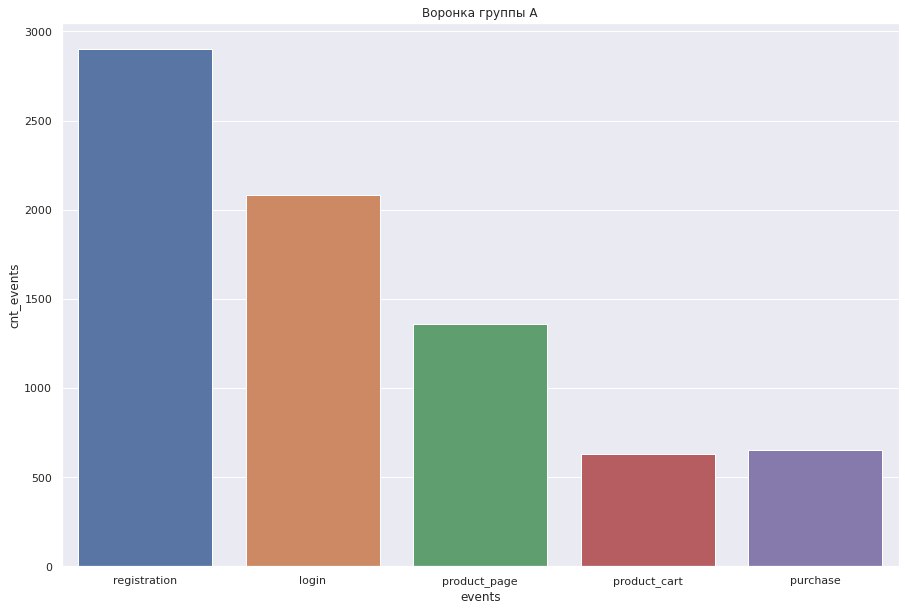

In [47]:
sns.barplot(data=funnel_A, x='event_name', y='user_id')
plt.title('Воронка группы А')
plt.xlabel('events')
plt.ylabel('cnt_events')
plt.show()

Итоговая воронка по группе А - готова. Обратите внимание, что у события просмотр корзины значение меньше, чем у события покупка. Скорей всего связано с наличием обходного пути оплаты покупки, без участия корзины

In [48]:
#посчитала конверсию к первому шагу и предыдущему
funnel_A['ratio_first'] = round(funnel_A['user_id']/total_A_new*100,2)
funnel_A['ratio_prev'] = round(funnel_A['user_id']/funnel_A['user_id'].shift(1, fill_value=0)*100,2)
funnel_A

,event_name,user_id,ratio_first,ratio_prev
4,registration,2903,100.00,inf
0,login,2082,71.72,71.72
2,product_page,1360,46.85,65.32
1,product_cart,631,21.74,46.40
3,purchase,652,22.46,103.33


Узкие места

1. Конверсия к перовому шагу: получение логина и просмотр карточек
2. Конверсия к предыдущему шагу: просмотр корзины, но не забываем, что есть обходной путь оплаты покупки

In [49]:
funnel_B = test_ab_new.query('group == "B"').groupby('event_name').agg({'user_id':'nunique'}).reset_index()
funnel_B

,event_name,user_id
0,login,705
1,product_cart,195
2,product_page,397
3,purchase,198
4,registration,1490


необходимо учесть при построении воронки, что по факту зарегистрировалось - 2196. И только 755 получили логин, посмотрели карточки - 397, посмотрели корзину - 195 и купили - 198

In [50]:
funnel_B.loc[4, 'user_id'] = 2196
funnel_B = funnel_B.reindex([4, 0, 2, 1, 3])
funnel_B

,event_name,user_id
4,registration,2196
0,login,705
2,product_page,397
1,product_cart,195
3,purchase,198


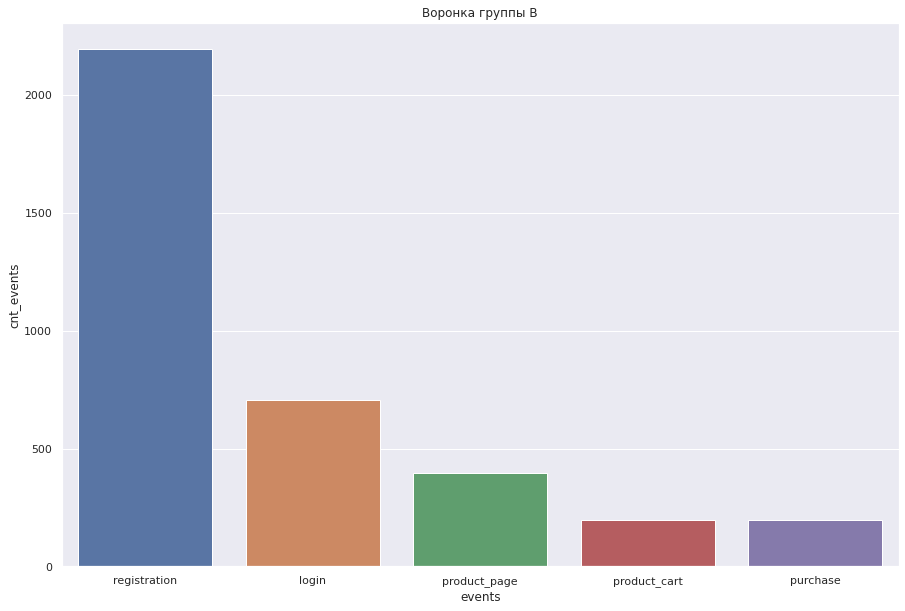

In [51]:
sns.barplot(data=funnel_B, x='event_name', y='user_id')
plt.title('Воронка группы B')
plt.xlabel('events')
plt.ylabel('cnt_events')
plt.show()

Итоговая воронка по группе B - готова. Обратите внимание, что у события просмотр корзины значение меньше, чем у события покупка. Скорей всего связано с наличием обходного пути оплаты покупки, без участия корзины

In [52]:
#посчитала конверсию к первому шагу и предыдущему
funnel_B['ratio_first'] = round(funnel_B['user_id']/total_B_new*100,2)
funnel_B['ratio_prev'] = round(funnel_B['user_id']/funnel_B['user_id'].shift(1, fill_value=0)*100,2)
funnel_B

,event_name,user_id,ratio_first,ratio_prev
4,registration,2196,100.00,inf
0,login,705,32.10,32.10
2,product_page,397,18.08,56.31
1,product_cart,195,8.88,49.12
3,purchase,198,9.02,101.54


Отвратительная воронка, на каждом шаге узкое место, есть предположение, что при настройке новой платежной воронки сломали весь функционал

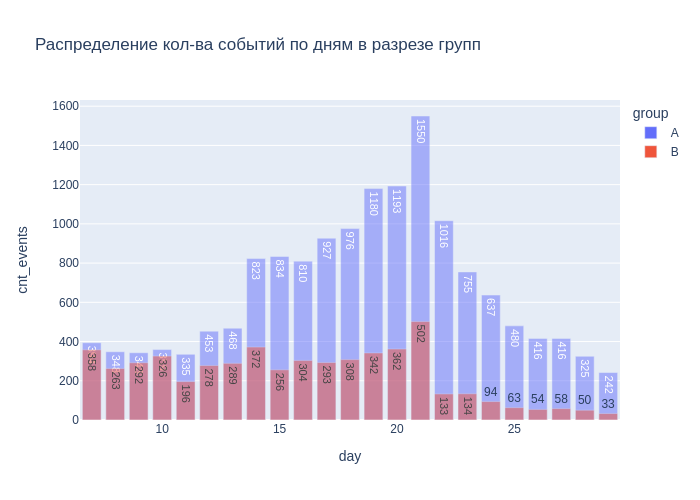

In [53]:
#посмотрела как число событий в выборках распределено по дням между группами
test_ab_new_cnt = (
    test_ab_new.groupby(['day', 'group'])
    .agg({'event_name':'count'}
    )
    .reset_index()
    .sort_values(by='event_name', ascending=False)
)
test_ab_new_cnt.columns = ['day', 'group', 'cnt_events']

fig = px.bar(
    test_ab_new_cnt, 
    x='day', 
    y='cnt_events', 
    color='group', 
    barmode='overlay', 
    text='cnt_events',
    title='Распределение кол-ва событий по дням в разрезе групп'
)
fig.show()

Значительная динамика роста начинается с 15 числа и заканчивается 21, далее спад. Теперь понятно почему тест был завершен 30 числа, так как не было необходимости далее продолжать тест, кол-во событий снижалось. Плюс группа А лидировала на протяжении всего теста, группа B в итоге оказалось неэффективной

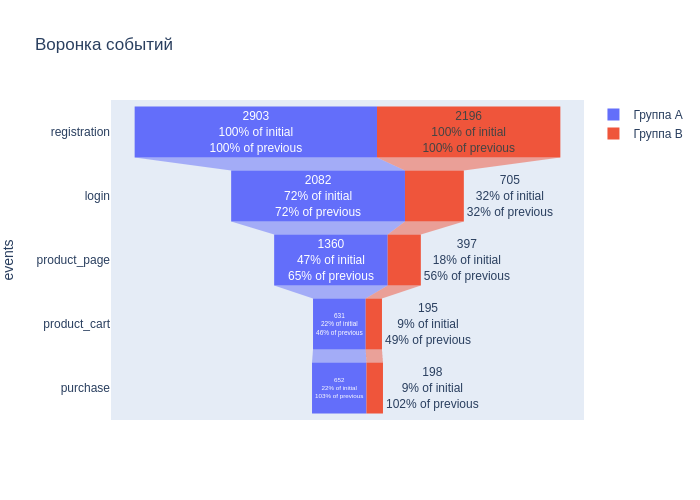

In [54]:
fig = go.Figure()

fig.add_trace(go.Funnel(name='Группа А',
                        y=funnel_A['event_name'],
                        x=funnel_A['user_id'],
                        textinfo="value+percent initial+percent previous"))

fig.add_trace(go.Funnel(name='Группа B',
                        y=funnel_B['event_name'],
                        x=funnel_B['user_id'],
                        textinfo="value+percent initial+percent previous"))
fig.update_layout(title='Воронка событий',
                 yaxis_title='events')
    
fig.show()

In [55]:
#проанализировала пользователей, которые не совершали событий после регистрации
reg = test_ab_new.query('event_name == "registration"')['user_id'].nunique()
total = test_ab_new['user_id'].nunique()
print('Кол-во пользователей, которые только зарегистрировались -', reg)
print('Доля участников в общем кол-ве -', round(reg/total*100, 2))

Кол-во пользователей, которые только зарегистрировались - 2311
Доля участников в общем кол-ве - 45.32


In [56]:
test_ab_new.query('event_name == "registration"').groupby('group')['user_id'].nunique()

group
A     821
B    1490
Name: user_id, dtype: int64

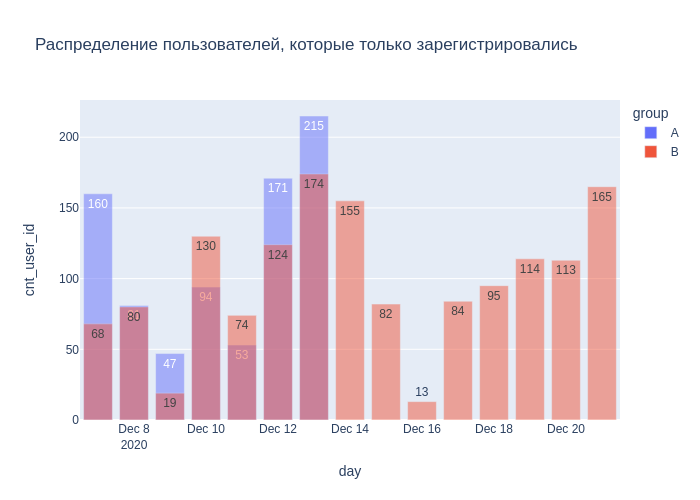

In [57]:
reg_fig = (
    test_ab_new.query('event_name == "registration"')
    .groupby(['event_dt', 'group'])
    .agg({'user_id':'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

reg_fig.columns = ['day', 'group', 'сnt_user_id']

fig = px.bar(
    reg_fig, 
    x='day', 
    y='сnt_user_id', 
    color='group', 
    barmode='overlay', 
    text='сnt_user_id',
    title='Распределение пользователей, которые только зарегистрировались'
)
fig.show()

In [58]:
(
    test_ab_new.query('event_name == "registration"')
    .groupby(['region'])
    .agg({'user_id':'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

,region,user_id
2,EU,2155
3,N.America,104
0,APAC,27
1,CIS,25


**Промежуточный вывод**

1. 45% пользователей от всех участников теста только зарегистрировались
2. 70% пользователей из группы B
3. после 14 числа концентрация подобных клиентов осталась только в группе В
4. Почти все пользователи из EU

**Промежуточный вывод**
1.	На протяжении теста лидировала группа А, как по конверсии, так и по кол-ву событий. Группа В оказалась неэффективной - показатели по конверсии и кол-ву событий ниже в несколько раз относительно контрольной группы А
2.	Тест закончен раньше из-за снижения активности пользователей
3.  45% пользователей от всех участников теста только зарегистрировались
4.  Тест можно считать провальным

**Особенности, которые необходимо учесть прежде, чем приступать к A/B-тестированию**
1. Исходные данные частично соответствуют условиям ТЗ
2. Группа А эффективнее в несколько раз, чем группа B
3. При расчете конверсии важно учесть, что покупки могут проходить без перехода в корзину

## Оценка результата A/B-тестирования

**Z-тест для пропорций**

**H_0**: Доля конверсии группы А по каждому этапу =  Доле конверсии группы В по каждому этапу

**H_1**: Доля конверсии группы А по каждому этапу ≠ Доле конверсии группы B по каждому этапу

alpha = 0.05

In [59]:
#проверила статистическую разницу долей z-критерием
users_test_ab_group['total'] = users_test_ab_group['A'] + users_test_ab_group['B']
users_test_ab_group

group
A        2903
B        2196
total    5099
Name: user_id, dtype: int64

In [60]:
funnel = funnel_A.merge(funnel_B, on='event_name', how='inner', suffixes=('_A', '_B'))
funnel = funnel.query('event_name != "registration"').reset_index(drop=True)
funnel = funnel[['event_name', 'user_id_A', 'user_id_B']]
funnel['total'] = funnel['user_id_A'] + funnel['user_id_B']
funnel.columns = ['event_name', 'A', 'B', 'total']
funnel

,event_name,A,B,total
0,login,2082,705,2787
1,product_page,1360,397,1757
2,product_cart,631,195,826
3,purchase,652,198,850


In [61]:
def z_test_check (group1, group2, alpha):
    for i in funnel.index: 
        p1=funnel[group1][i]/users_test_ab_group[group1]
        p2=funnel[group2][i]/users_test_ab_group[group2]
        p_combined=((funnel[group1][i]+funnel[group2][i])/(users_test_ab_group[group1]+users_test_ab_group[group2]))
        difference=p1-p2
        z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/users_test_ab_group[group1]+1/users_test_ab_group[group2]))
        distr=stats.norm(0, 1)
        p_value=(1-distr.cdf(abs(z_value)))*2 
        print ('{} p-значение:{}'.format(funnel['event_name'][i], p_value)) 
        if (p_value<alpha ): 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница') 
        else: 
            print('Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [62]:
z_test_check('A', 'B', 0.05)

login p-значение:0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
product_page p-значение:0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
product_cart p-значение:0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
purchase p-значение:0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Между группами между долями есть значимая разница, также это показывает исследовательский анализ

## Вывод и рекомендации

**Вывод**
1. Тест можно считать провальным
2. На протяжении теста лидировала группа А, как по конверсии, так и по кол-ву событий. Группа В оказалась неэффективной - показатели по конверсии и кол-ву событий ниже в несколько раз относительно контрольной группы А
3. Тест закончен раньше из-за снижения активности пользователей
4. Тест пересекается с маркетинговыми активностями, высок риск искаженных результатов
5. Изначально выборка была сделана некорректно, из-за этого 24% данных было потеряно
6. Большинство участников теста из EU (70%), хотя в других регионах также пользуются приложением

**Рекомендации**
1. Более тщательно готовится к тестированию, проверять изначальную выборку, минимизировать пересечения с конкурирующим тестом и исключить на этапе тестирования маркетинговые акции
2. Проверить приложение на технические аспекты/путь клиента, так как около 40% клиентов после регистрации не доходят до получения логина. В том числе самый большой % потери был зафиксирован в группе В, возможно при настройке новой платежной воронки задели весь функционал